In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from typing import Tuple, List
import numpy as np
from keras.datasets import mnist

class LeNet5(nn.Module):
    def __init__(self, num_classes: int = 10):
        """
        Initialize the LeNet-5 architecture.

        Parameters:
            num_classes (int): Number of output classes
        """
        super(LeNet5, self).__init__()

        # Convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, num_classes)
        )

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize network weights using Xavier initialization."""
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Perform the forward pass through the network.

        Parameters:
            x (torch.Tensor): Input image batch of shape (batch_size, 1, height, width)

        Returns:
            torch.Tensor: Output predictions of shape (batch_size, num_classes)
        """

        # Convolutional layers
        x = self.conv_layers(x)

        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.fc_layers(x)

        return x

    def train_model(self,
                    train_loader: DataLoader,
                    test_loader: DataLoader,  # Thêm test_loader để đánh giá sau mỗi epoch
                    num_epochs: int,
                    learning_rate: float,
                    device: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
        """
        Train the LeNet-5 model and log metrics.
        """
        self.to(device)

        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)

        # Initialize lists to store metrics
        train_losses = []
        train_accuracies = []
        test_accuracies = []

        # Training loop
        for epoch in range(num_epochs):
            self.train()  # Set model to training mode
            running_loss = 0.0
            correct = 0
            total = 0

            # Training phase
            for i, (inputs, labels) in enumerate(train_loader):
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # Calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                running_loss += loss.item()

                if i % 500 == 499:
                    print(f'[Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss/100:.4f}')
                    running_loss = 0.0

            # Calculate epoch metrics
            epoch_loss = running_loss / len(train_loader)
            epoch_accuracy = 100 * correct / total

            # Evaluate on test set
            test_accuracy = self.evaluate(test_loader, device)

            # Store metrics
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_accuracy)
            test_accuracies.append(test_accuracy)

            # Print epoch summary
            print(f'Epoch {epoch + 1}/{num_epochs}:')
            print(f'Training Loss: {epoch_loss:.4f}')
            print(f'Training Accuracy: {epoch_accuracy:.2f}%')
            print(f'Test Accuracy: {test_accuracy:.2f}%')
            print('-' * 60)

        # Return training history
        history = {
            'train_loss': train_losses,
            'train_acc': train_accuracies,
            'test_acc': test_accuracies
        }

        return history

    def predict(self,
                test_loader: DataLoader,
                device: torch.device) -> np.ndarray:
        """
        Make predictions using GPU if available.
        """
        self.eval()  # Set to evaluation mode
        predictions = []

        with torch.no_grad():
            for inputs, _ in test_loader:
                inputs = inputs.to(device)  # Chuyển input sang device
                outputs = self(inputs)
                _, predicted = torch.max(outputs.data, 1)
                predictions.extend(predicted.cpu().numpy())  # Chuyển kết quả về CPU trước khi chuyển sang numpy

        return np.array(predictions)
    def evaluate(self,
                test_loader: DataLoader,
                device: torch.device) -> float:
        """
        Evaluate model accuracy using GPU if available.
        """
        self.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = self(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f'Accuracy on test set: {accuracy:.2f}%')
        return accuracy
def plot_training_history(history):
    import matplotlib.pyplot as plt

    # Plot training loss
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'])
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['test_acc'], label='Test')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [11]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Initialize model and move to GPU
model = LeNet5(num_classes=10)
model = model.to(device)

# Prepare data
def prepare_data(X: np.ndarray, y: np.ndarray, batch_size: int) -> DataLoader:
    # normalize data
    X = X.astype(np.float32)
    if X.max() > 1.0:
        X = X / 255.0

    if len(X.shape) == 3:
        X = X.reshape(-1, 1, X.shape[1], X.shape[2])

    # convert to tensor
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.LongTensor(y)

    # create dataset
    dataset = TensorDataset(X_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return dataloader

# Prepare data loaders
train_loader = prepare_data(X_train, y_train, batch_size=32)
test_loader = prepare_data(X_test, y_test, batch_size=32)

# Train model with GPU
history = model.train_model(
    train_loader=train_loader,
    test_loader=test_loader,
    num_epochs=10,
    learning_rate=0.001,
    device=device
)

Using device: cuda
[Epoch 1, Batch 500] Loss: 1.8993
[Epoch 1, Batch 1000] Loss: 0.5883
[Epoch 1, Batch 1500] Loss: 0.4270
Accuracy on test set: 98.10%
Epoch 1/10:
Training Loss: 0.0154
Training Accuracy: 94.71%
Test Accuracy: 98.10%
------------------------------------------------------------
[Epoch 2, Batch 500] Loss: 0.3177
[Epoch 2, Batch 1000] Loss: 0.3182
[Epoch 2, Batch 1500] Loss: 0.2823
Accuracy on test set: 98.90%
Epoch 2/10:
Training Loss: 0.0103
Training Accuracy: 98.17%
Test Accuracy: 98.90%
------------------------------------------------------------
[Epoch 3, Batch 500] Loss: 0.2325
[Epoch 3, Batch 1000] Loss: 0.2182
[Epoch 3, Batch 1500] Loss: 0.2033
Accuracy on test set: 98.44%
Epoch 3/10:
Training Loss: 0.0079
Training Accuracy: 98.66%
Test Accuracy: 98.44%
------------------------------------------------------------
[Epoch 4, Batch 500] Loss: 0.1692
[Epoch 4, Batch 1000] Loss: 0.1652
[Epoch 4, Batch 1500] Loss: 0.1600
Accuracy on test set: 98.85%
Epoch 4/10:
Training

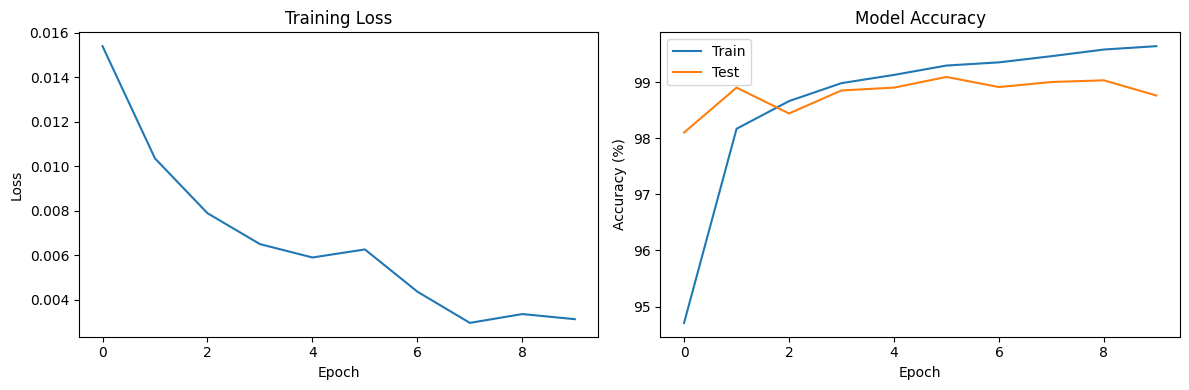

In [13]:
plot_training_history(history)